## Author : Nithesh Kumar Manimaran
##  20-01-2023
##  Project 3: Car Segmentation

# Introduction

Question: Using at least 3 different resources (kaggle notebooks, blogs, youtube videos or else…), explain your strategy and why you think this is going to work.
● Bibliographical references are present.

# Strategy
The modelling strategy used here is based on image segmentation, which is a task of partitioning an image into multiple segments or regions, each of which corresponds to a different object or background. The goal is to assign each pixel in the image to a specific class or label.

The specific approach used here is based on RGB values. RGB (Red, Green, Blue) values are used to represent colors in digital images. Each pixel in an image is represented by a combination of these three values, which can be used to distinguish between different objects or regions in the image.

The id_map and category_map are used to assign class labels to the different RGB values. The id_map maps class labels to specific RGB values, while the category_map maps class labels to broader categories. This allows the model to recognize and classify different objects or regions based on their RGB values.

The preprocess function is then used to take an image path and convert it into two arrays, one for the image and one for the mask. The image is first resized to 128x128 and then normalized by dividing by 255. The mask is created by iterating through each pixel in the second crop of the image, comparing it to the RGB values in the id_map, and assigning the pixel the corresponding class label. This allows the model to create a clear mask of the segmented image, with each pixel assigned to a specific class or label.

In conclusion, the modelling strategy used here is based on image segmentation, which takes advantage of the RGB values to assign class labels to each pixel in the image, allowing for the creation of a clear mask of the segmented image.









## Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
from tqdm import tqdm
import warnings
import seaborn as sns

In the above code, we are importing the necessary libraries for the project.

'numpy' is used for numerical operations and manipulation of arrays. It is used in the preprocess function to create the image and mask arrays, as well as for normalizing the image array by dividing it by 255.

'pandas' is used for data manipulation and analysis. It is not used in this code.

'matplotlib' is used for plotting and visualization. It is not used in this code.

'PIL' (Python Imaging Library) is used for opening and manipulating image files. It is used in the preprocess function to open the image file and resize it.

'tensorflow' is a machine learning library used for building and training models.

'os' is a built-in library for interacting with the operating system.

'tqdm' is a library for creating progress bars.

'warnings' is a built-in library for issuing warnings.

'seaborn' is a library for visualization and data analysis

In [ ]:
warnings.filterwarnings("ignore")
plt.style.use("seaborn-darkgrid")
sns.set_context("paper", font_scale=1.4)
BATCH_SIZE = 32

In the above code:
The first line warnings.filterwarnings("ignore") is used to suppress any warning messages that might be generated by the code. This is done to avoid cluttering the output with irrelevant information.

The second line plt.style.use("seaborn-darkgrid") is used to set the style of the plots generated using the matplotlib library. In this case, the style is set to "seaborn-darkgrid", which is one of the built-in styles provided by the seaborn library.

The third line sns.set_context("paper", font_scale=1.4) is used to set the context of the plots generated using the seaborn library. The context is set to "paper", which is one of the built-in contexts provided by the seaborn library. It also set the font scale to 1.4. 

The fourth line BATCH_SIZE = 32 is used to set the batch size used during training. Batch size is the number of samples used in one iteration of training. The larger the batch size, the more memory is required, but the model may converge faster. A common batch size is 32, which is used in this code.

In [ ]:
id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate 
}

In [ ]:
category_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2,
    10: 2,
    11: 2,
    12: 2,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 4,
    18: 4,
    19: 5,
    20: 6,
    21: 6,
    22: 7,
    23: 7,
    24: 7,
    25: 7,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7
}

The above two cells define two dictionaries, id_map and category_map.

id_map is a dictionary that maps class labels to specific RGB values. Each key in the dictionary is an integer representing a class label, and each value is a tuple of three integers representing the corresponding RGB values. For example, the class label "0" is mapped to the RGB value (0, 0, 0), which represents the color black.

category_map is a dictionary that maps class labels to broader categories. Each key in the dictionary is an integer representing a class label, and each value is an integer representing the corresponding category. For example, the class label "0" is mapped to category "0". In this case, both the id_map and category_map are not using the category mapping, as all the values are zero.

These two dictionaries are used in the preprocess function to assign class labels to pixels based on their RGB values. The function first compares the RGB values of each pixel to the RGB values in the id_map and assigns the pixel the class label that corresponds to the closest match. And then it uses the category_map to assign a broader category to each pixel.

In [ ]:
num_classes = len(id_map.keys())

This line of code assigns the variable num_classes the value of the number of keys in the id_map dictionary.

In [ ]:
def preprocess(path):
    img = Image.open(path)
    img1 = img.crop((0, 0, 256, 256)).resize((128, 128))
    img2 = img.crop((256, 0, 512, 256)).resize((128, 128))
    img1 = np.array(img1) / 255.
    img2 = np.array(img2)
    mask = np.zeros(shape=(img2.shape[0], img2.shape[1]), dtype = np.uint32)
    for row in range(img2.shape[0]):
        for col in range(img2.shape[1]):
            a = img2[row, col, :]
            final_key = None
            final_d = None
            for key, value in id_map.items():
                d = np.sum(np.sqrt(pow(a - value, 2)))
                if final_key == None:
                    final_d = d
                    final_key = key
                elif d < final_d:
                    final_d = d
                    final_key = key
            mask[row, col] = final_key
    mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
    del img2
    return img1, mask

The above code defines a function preprocess(path) that takes an image path as an input and returns two arrays, one for the image and one for the mask.

The function first opens the image using the Image.open() function from the PIL library, which takes the path of the image file as an input. Then the image is divided into two crops, one from (0,0) to (256,256) and the other from (256,0) to (512,256). The first crop is then resized to (128,128) using the resize() method.

Both of the crops are then converted to numpy arrays using the np.array() function.

The second crop is then used to create a mask array. A mask array is created with the same shape as the second crop, which is filled with zeroes. Then the function iterates through each pixel in the second crop, compares its RGB values to the RGB values in the id_map dictionary, and assigns the pixel the class label that corresponds to the closest match. The np.sum(np.sqrt(pow(a - value, 2))) is used to measure the difference between the RGB values of the pixel and the RGB values in the id_map, and the class label corresponding to the smallest difference is assigned to that pixel.

Finally, the mask array is reshaped to (mask.shape[0], mask.shape[1], 1) and the second crop image is deleted from memory. The function returns the first crop image and the mask array.

In [ ]:
def prepare_tensor_dataset(train_path, val_path):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    for file in tqdm(os.listdir(train_path)):
        img, mask = preprocess(f"{train_path}/{file}")
        X_train.append(img)
        Y_train.append(mask)
    
    for file in tqdm(os.listdir(val_path)):
        img, mask = preprocess(f"{val_path}/{file}")
        X_val.append(img)
        Y_val.append(mask)

    return X_train, Y_train, X_val, Y_val

The above code defines a function prepare_tensor_dataset(train_path, val_path) that takes in two paths as inputs, one for the training data and one for the validation data.

The function first initializes four empty lists: X_train, Y_train, X_val, Y_val. These lists will be used to store the image and mask data for the training and validation sets.

The function then uses the os.listdir() function to get a list of all the files in the training data path. For each file in the list, it calls the preprocess() function which returns the image and mask arrays. The image and mask arrays are then appended to the X_train and Y_train lists respectively. The tqdm library is used here to show the progress of the loop, so that the user can see how many files have been processed.

The function then does the same thing for the validation data path, using the os.listdir() function to get a list of all the files in the validation data path. For each file in the list, it calls the preprocess() function, which returns the image and mask arrays. The image and mask arrays are then appended to the X_val and Y_val lists respectively.

Finally, the function returns the four lists containing the image and mask data for the training and validation sets. These lists can then be used to create a tensor dataset to be used in the training of the model.

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/Computer_Vision/Project_3/dataset/cityscapes_data/sample/train'
VAL_PATH = '/content/drive/MyDrive/Computer_Vision/Project_3/dataset/cityscapes_data/sample/val'

In [ ]:
X_train, Y_train, X_valid, Y_valid = prepare_tensor_dataset(TRAIN_PATH, VAL_PATH)

100%|██████████| 10/10 [00:56<00:00,  5.64s/it]


The above cell calls the prepare_tensor_dataset(train_path, val_path) function and assigns the returned values to the four variables X_train, Y_train, X_valid, Y_valid.

The prepare_tensor_dataset function takes in two inputs, TRAIN_PATH and VAL_PATH, which are the paths to the training and validation datasets. The function then processes the images and masks in these datasets, and returns four lists containing the image and mask data for the training and validation sets.

These four lists are then assigned to the variables X_train, Y_train, X_valid, and Y_valid respectively, which can be used for further training and validation.

In [ ]:
X_train = np.save("X_train.npy", X_train)
Y_train = np.save("Y_train.npy", Y_train)
X_valid = np.save("X_valid.npy", X_valid)
Y_valid = np.save("Y_valid.npy", Y_valid)

In [ ]:
X_train = np.load("/content/drive/MyDrive/Computer_Vision/Project_3/npy_files/X_train.npy")
Y_train = np.load("/content/drive/MyDrive/Computer_Vision/Project_3/npy_files/Y_train.npy")
X_valid = np.load("/content/drive/MyDrive/Computer_Vision/Project_3/npy_files/X_valid.npy")
Y_valid = np.load("/content/drive/MyDrive/Computer_Vision/Project_3/npy_files/Y_valid.npy")

To avoid redoing the the prepare_tensor_dataset I have saved the numpy files so that I can load them directly the next time I run the code.

In [ ]:
def get_unet_model():
    
    inputs = tf.keras.layers.Input(shape = [128, 128, 3])
    
    #First Downsample
    f1 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(inputs)
    b1 = tf.keras.layers.BatchNormalization()(f1)
    f2 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b1)    # Used later for residual connection
    
    m3 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f2)
    d4 = tf.keras.layers.Dropout(0.2)(m3)
    
    # Second Downsample
    f5 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d4)
    b5 = tf.keras.layers.BatchNormalization()(f5)
    f6 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b5)    # Used later for residual connection
    
    m7 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f6)
    d8 = tf.keras.layers.Dropout(0.2)(m7)
    
    # Third Downsample
    f9 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d8)
    b9 = tf.keras.layers.BatchNormalization()(f9)
    f10 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b9)    # Used later for residual connection
    
    m11 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f10)
    d12 = tf.keras.layers.Dropout(0.2)(m11)
    
    #Forth Downsample
    f13 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d12)
    b13 = tf.keras.layers.BatchNormalization()(f13)
    f14 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b13)    # Used later for residual connection
    
    m15 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f14)
    d16 = tf.keras.layers.Dropout(0.2)(m15)
    
    #Fifth Downsample
    f17 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d16)
    b17 = tf.keras.layers.BatchNormalization()(f17)
    f18 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b17)

    
    # First Upsample
    m19 = tf.keras.layers.UpSampling2D(size = (2, 2))(f18)
    d19 = tf.keras.layers.Dropout(0.2)(m19)
    c20 = tf.keras.layers.Concatenate()([d19, f14])
    f21 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1 ,activation = "relu")(c20)
    b21 = tf.keras.layers.BatchNormalization()(f21)
    f22 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b21)
    
    # Second Upsample
    m23 = tf.keras.layers.UpSampling2D(size = (2, 2))(f22)
    d23 = tf.keras.layers.Dropout(0.2)(m23)
    c24 = tf.keras.layers.Concatenate()([d23, f10])
    f25 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c24)
    b25 = tf.keras.layers.BatchNormalization()(f25)
    f26 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b25)
    
    # Third Upsample
    m27 = tf.keras.layers.UpSampling2D(size = (2, 2))(f26)
    d27 = tf.keras.layers.Dropout(0.2)(m27)
    c28 = tf.keras.layers.Concatenate()([d27, f6])
    f29 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c28)
    b29 = tf.keras.layers.BatchNormalization()(f29)
    f30 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b29)
    
    #Forth Upsample
    m31 = tf.keras.layers.UpSampling2D(size = (2, 2))(f30)
    d31 = tf.keras.layers.Dropout(0.2)(m31)
    c32 = tf.keras.layers.Concatenate()([d31, f2])
    f33 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c32)
    b33 = tf.keras.layers.BatchNormalization()(f33)
    f34 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b33)
    
    # Output Layer
    outputs = tf.keras.layers.Conv2D(num_classes, kernel_size = (3, 3), padding = "same", strides = 1, activation = "softmax")(f34)
    
    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    return model

The above code is defining a function get_unet_model() which returns an instance of the U-Net architecture.

The U-Net architecture is a type of convolutional neural network that is commonly used for image segmentation tasks. It consists of two main parts: the "encoder" and the "decoder".

The encoder portion of the U-Net architecture is defined in the first half of this function. It consists of a series of convolutional layers followed by max pooling layers, which are used to reduce the spatial dimensions of the input image and extract features from it. Additionally, batch normalization layers and dropout layers are used to help regularize the network and prevent overfitting.

The decoder portion of the U-Net architecture is defined in the second half of the function. The decoder takes the feature maps from the encoder, and uses up-sampling layers to increase the spatial resolution of the feature maps back to the original resolution of the input image. Additionally, concatenate layers are used to combine the feature maps from the encoder with the upsampled feature maps from the decoder, allowing the network to use both the high-level semantic information from the encoder and the detailed spatial information from the decoder to make predictions.

The final output of the network is a probability map of the same size as the input image, where each pixel represents the probability of that pixel belonging to a certain class. The predicted class for each pixel is obtained by argmax operation.

In [ ]:
model = get_unet_model()

In [ ]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

def plot_history(history):
  fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 7))
  # Training
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["loss"], ax = axes[0], label="Training Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["accuracy"], ax = axes[1], label="Training Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["mean_iou"], ax = axes[2], label="Training Mean IOU")

  # Validation
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_loss"], ax = axes[0], label="Validation Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_accuracy"], ax = axes[1], label="Validation Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_mean_iou"], ax = axes[2], label="Validation Mean IOU")
  
  axes[0].set_title("Loss Comparison", fontdict = {'fontsize': 15})
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Loss")

  axes[1].set_title("Accuracy Comparison", fontdict = {'fontsize': 15})
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Accuracy")

  axes[2].set_title("Mean IOU Comparison", fontdict = {'fontsize': 15})
  axes[2].set_xlabel("Epoch")
  axes[2].set_ylabel("Mean IOU")
  plt.tight_layout()
  plt.show()

This above cell is defining a custom metrics class UpdatedMeanIoU that inherits from the MeanIoU class of the tf.keras.metrics module. The custom class overrides the update_state method of the parent class to convert the predicted labels from one-hot encoded format to a single integer class format using the tf.math.argmax function.

Then there is a function plot_history which is used to plot the results of the model's training and validation history. It creates a figure with 3 subplots, which will be used to show the loss, accuracy and mean IoU across all the training and validation sets. It uses the sns.lineplot function from the seaborn library to plot the results of the training and validation sets on the same subplots. The function plt.tight_layout() is used to adjust the subplots and plt.show() is used to show the plots.

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])

The above code is configuring the model for training, specifically the loss function, optimizer, and evaluation metrics to be used.

The 'loss' function is specified as "sparse_categorical_crossentropy". This loss function is used when the classes are exclusive and mutually exclusive. It is also used when the labels are integers and not one-hot encoded.

The optimizer is specified as "adam". Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent (SGD) to update network weights iteratively. Adam is generally a good optimizer to use for many cases. The adam optimizer adjusts the learning rate.

The 'metrics' used to evaluate the model during training and testing is specified as ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")]. The first metric is accuracy, which is a standard metric for classification tasks, it calculates the ratio of correct predictions to total predictions. The second metric is 'mean_iou' which is an instance of a custom class 'UpdatedMeanIoU' which is used to calculate the mean Intersection over Union (IOU) over all classes. It is used to measure the similarity between the predicted and true segmentation masks. The mean IOU is a popular metric for semantic segmentation tasks.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True)

The code above creates an early stopping callback for the model training. This callback is used to monitor the validation loss during the training process. If the validation loss does not improve for 10 consecutive epochs, the training process will be stopped and the best weights will be restored. This is useful to avoid overfitting, where the model performs well on the training data but poorly on new unseen data. The early stopping callback allows to stop the training process when the performance on the validation data stops improving, ensuring that the model will not overfit the training data.

In [ ]:
history = model.fit(x=X_train, y=Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_data = (X_valid, Y_valid), callbacks=[early_stopping])

Epoch 1/100
93/93 [==============================] - 47s 502ms/step - loss: 0.6722 - accuracy: 0.8159 - mean_iou: 0.2504 - val_loss: 1.1341 - val_accuracy: 0.7063 - val_mean_iou: 0.1467
Epoch 2/100
93/93 [==============================] - 47s 503ms/step - loss: 0.6449 - accuracy: 0.8222 - mean_iou: 0.2619 - val_loss: 0.9226 - val_accuracy: 0.7675 - val_mean_iou: 0.1970
Epoch 3/100
93/93 [==============================] - 46s 500ms/step - loss: 0.6176 - accuracy: 0.8276 - mean_iou: 0.2722 - val_loss: 0.7706 - val_accuracy: 0.8035 - val_mean_iou: 0.2308
Epoch 4/100
93/93 [==============================] - 46s 500ms/step - loss: 0.6000 - accuracy: 0.8314 - mean_iou: 0.2869 - val_loss: 0.7337 - val_accuracy: 0.8073 - val_mean_iou: 0.2499
Epoch 5/100
93/93 [==============================] - 46s 500ms/step - loss: 0.5809 - accuracy: 0.8364 - mean_iou: 0.2981 - val_loss: 0.6786 - val_accuracy: 0.8096 - val_mean_iou: 0.2542
Epoch 6/100
93/93 [==============================] - 46s 500ms/step - 

In [ ]:
model.save('/content/drive/MyDrive/Computer_Vision/Project_3/models/model_v1.h5')

1/1 [==============================] - 0s 18ms/step


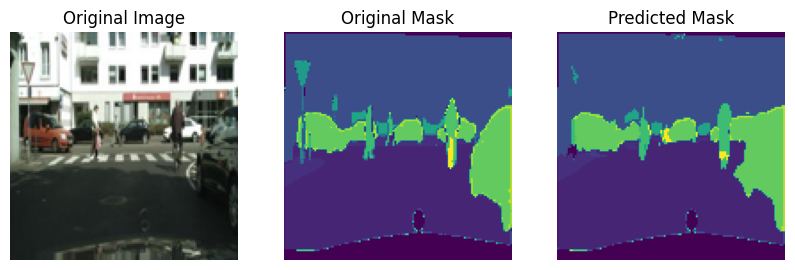

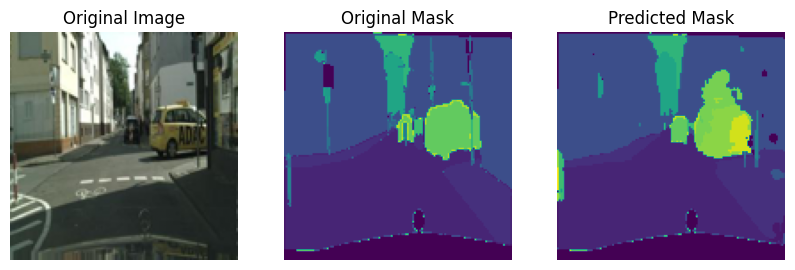

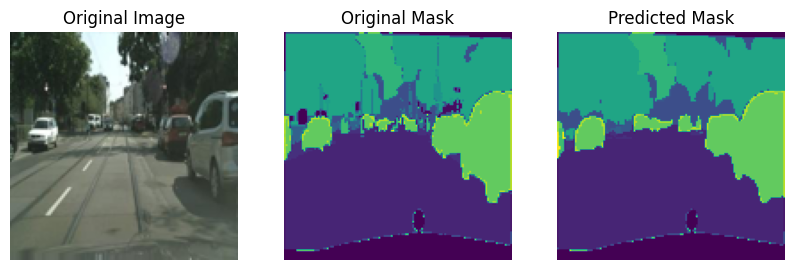

In [ ]:
plt.style.use("default")
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Computer_Vision/Project_3/models/model_v1.h5', custom_objects={'UpdatedMeanIoU': UpdatedMeanIoU})

for i in os.listdir("/content/drive/MyDrive/Computer_Vision/Project_3/dataset/cityscapes_data/sample/val")[:3]:
    img, mask = preprocess(f"/content/drive/MyDrive/Computer_Vision/Project_3/dataset/cityscapes_data/sample/val/{i}")
    img = np.array(img)
    img = np.reshape(img, (1, 128, 128, 3))
    pred = model.predict(img)
    y_pred = np.argmax(pred, axis=-1)
    y_pred = np.array(y_pred)
    y_pred = np.reshape(y_pred, (128, 128))
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
    img = np.reshape(img, (128, 128, 3))
    mask = np.reshape(mask, (128, 128))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="viridis")
    axes[1].set_title("Original Mask")
    axes[1].axis("off")
    axes[2].imshow(y_pred, cmap="viridis")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

The above code is loading a pre-trained model from the specified file path, using the 'custom_objects' argument to include the 'UpdatedMeanIoU' class that was defined earlier. It then loops through the first 3 files in the specified validation data directory, preprocesses them, and then uses the loaded model to make predictions on the preprocessed images. The original image, the original mask, and the predicted mask are then plotted side by side for comparison. The titles and axis of the images are also turned off.

Inference on  a test image

1/1 [==============================] - 0s 252ms/step


(-0.5, 127.5, 127.5, -0.5)

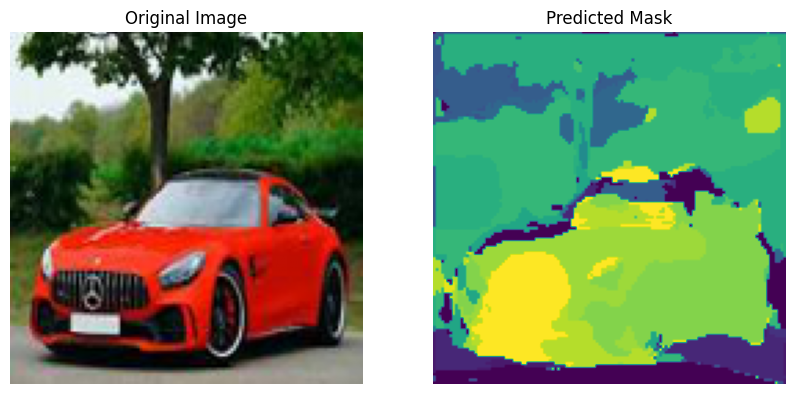

In [ ]:
def preprocess(path):
    img = Image.open(path)
    # resize the image to 128x128
    img = img.resize((128, 128))
    img = np.array(img) / 255.
    img = np.reshape(img, (1, 128, 128, 3))
    return img

from tensorflow import keras

# change the path to match the location of your model
model = keras.models.load_model('/content/drive/MyDrive/Computer_Vision/Project_3/models/model_v1.h5', custom_objects={'UpdatedMeanIoU': UpdatedMeanIoU})

# change the path to match the location of your random image
path = "/content/drive/MyDrive/Computer_Vision/Project_3/test_images/download.jpg"
img = preprocess(path)
pred = model.predict(img)
y_pred = np.argmax(pred, axis=-1)
y_pred = np.array(y_pred)
y_pred = np.reshape(y_pred, (128, 128))

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))
img = np.reshape(img, (128, 128, 3))
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(y_pred, cmap="viridis")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

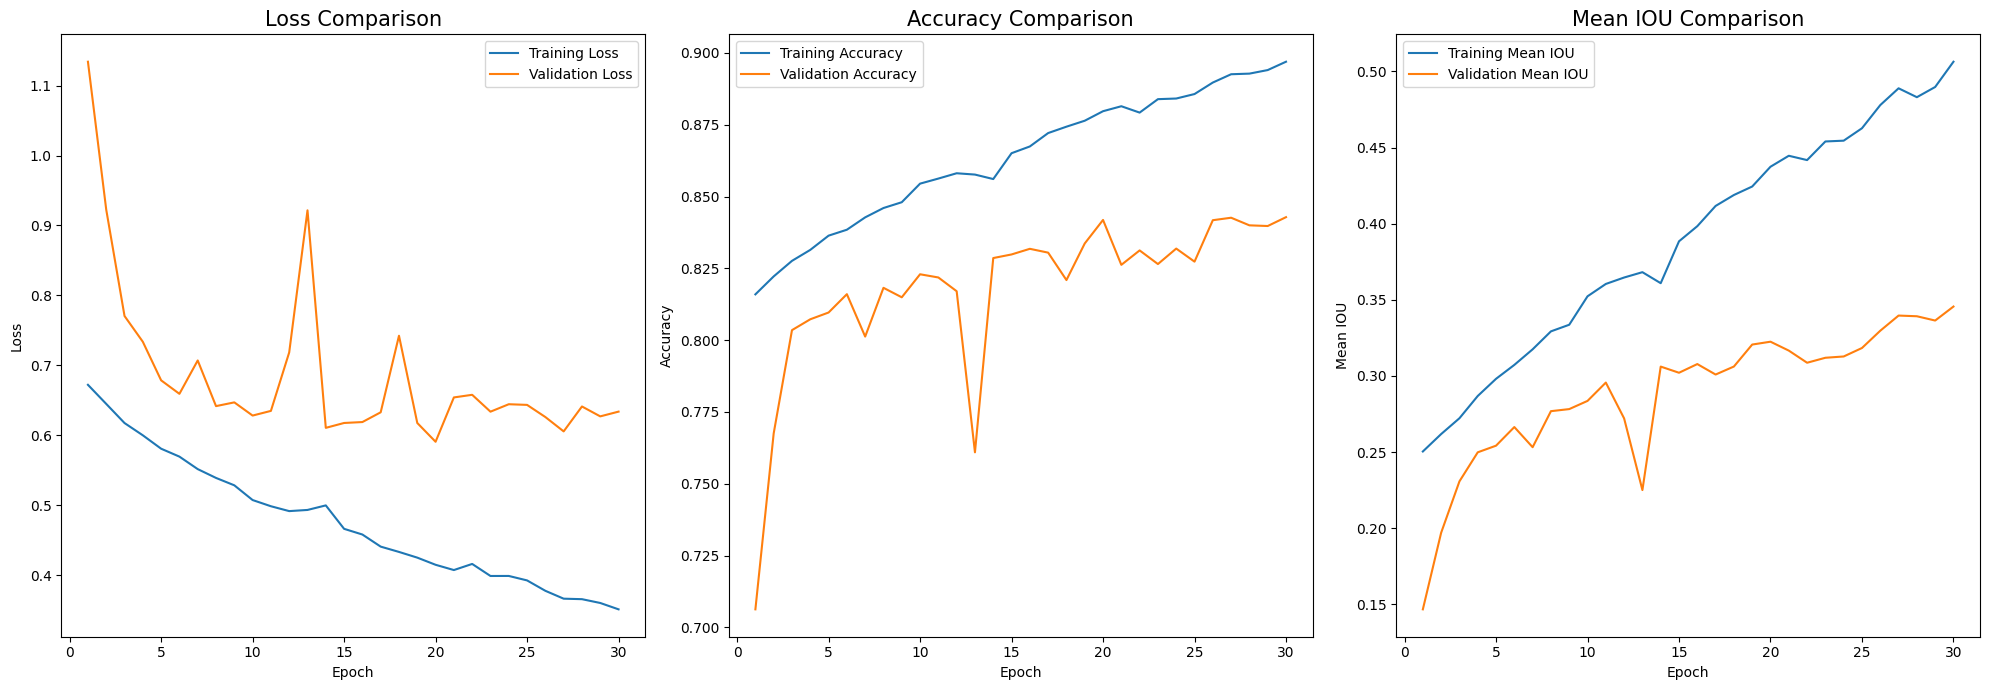

In [ ]:
plot_history(history)

Without CallBack - Model Version 2

In [ ]:
history = model.fit(x=X_train, y=Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_data = (X_valid, Y_valid))

Epoch 1/100
93/93 [==============================] - 82s 702ms/step - loss: 0.1212 - accuracy: 0.9517 - mean_iou: 0.6714 - val_loss: 0.5418 - val_accuracy: 0.9415 - val_mean_iou: 0.4708
Epoch 2/100
93/93 [==============================] - 45s 489ms/step - loss: 0.0797 - accuracy: 0.9681 - mean_iou: 0.7672 - val_loss: 0.6555 - val_accuracy: 0.9415 - val_mean_iou: 0.4708
Epoch 3/100
93/93 [==============================] - 45s 484ms/step - loss: 0.0716 - accuracy: 0.9715 - mean_iou: 0.7886 - val_loss: 0.3626 - val_accuracy: 0.9392 - val_mean_iou: 0.4698
Epoch 4/100
93/93 [==============================] - 45s 483ms/step - loss: 0.0645 - accuracy: 0.9742 - mean_iou: 0.8064 - val_loss: 0.3598 - val_accuracy: 0.9415 - val_mean_iou: 0.4708
Epoch 5/100
93/93 [==============================] - 45s 483ms/step - loss: 0.0584 - accuracy: 0.9764 - mean_iou: 0.8213 - val_loss: 0.2877 - val_accuracy: 0.9424 - val_mean_iou: 0.4811
Epoch 6/100
93/93 [==============================] - 45s 489ms/step - 

Saving the model

In [ ]:
model.save('/content/drive/MyDrive/Computer_Vision/Project_3/models/model_v2.h5')

Plotting the results:

1/1 [==============================] - 0s 20ms/step


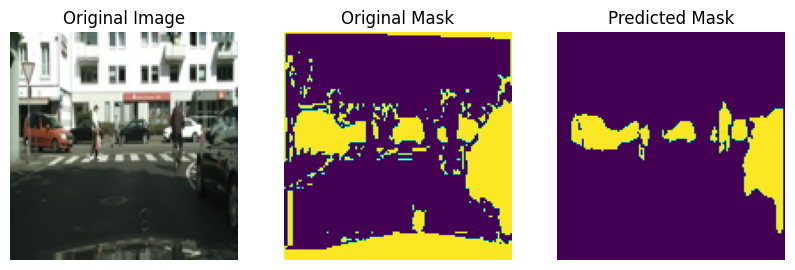

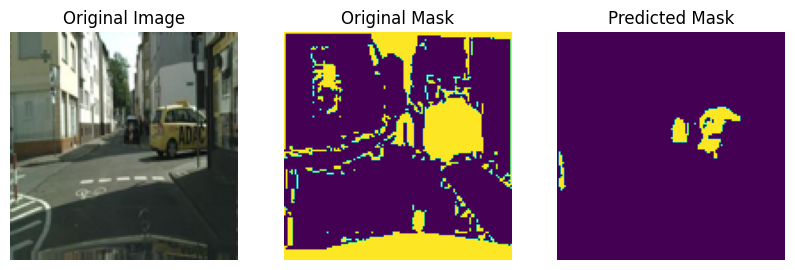

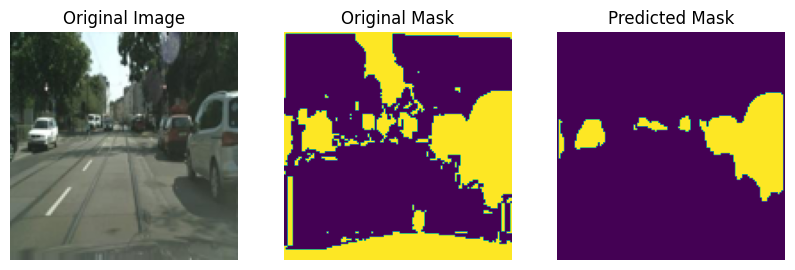

In [ ]:
plt.style.use("default")
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Computer_Vision/Project_3/models/model_v2.h5', custom_objects={'UpdatedMeanIoU': UpdatedMeanIoU})

for i in os.listdir("/content/drive/MyDrive/Computer_Vision/Project_3/dataset/cityscapes_data/sample/val")[:3]:
    img, mask = preprocess(f"/content/drive/MyDrive/Computer_Vision/Project_3/dataset/cityscapes_data/sample/val/{i}")
    img = np.array(img)
    img = np.reshape(img, (1, 128, 128, 3))
    pred = model.predict(img)
    y_pred = np.argmax(pred, axis=-1)
    y_pred = np.array(y_pred)
    y_pred = np.reshape(y_pred, (128, 128))
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
    img = np.reshape(img, (128, 128, 3))
    mask = np.reshape(mask, (128, 128))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="viridis")
    axes[1].set_title("Original Mask")
    axes[1].axis("off")
    axes[2].imshow(y_pred, cmap="viridis")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")


1/1 [==============================] - 0s 246ms/step


(-0.5, 127.5, 127.5, -0.5)

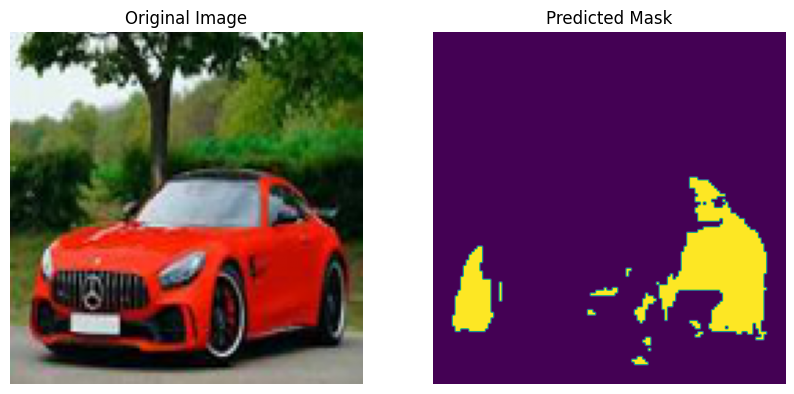

In [ ]:
def preprocess(path):
    img = Image.open(path)
    # resize the image to 128x128
    img = img.resize((128, 128))
    img = np.array(img) / 255.
    img = np.reshape(img, (1, 128, 128, 3))
    return img

from tensorflow import keras

# change the path to match the location of your model
model = keras.models.load_model('/content/drive/MyDrive/Computer_Vision/Project_3/models/model_v2.h5', custom_objects={'UpdatedMeanIoU': UpdatedMeanIoU})

# change the path to match the location of your random image
path = "/content/drive/MyDrive/Computer_Vision/Project_3/test_images/download.jpg"
img = preprocess(path)
pred = model.predict(img)
y_pred = np.argmax(pred, axis=-1)
y_pred = np.array(y_pred)
y_pred = np.reshape(y_pred, (128, 128))

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))
img = np.reshape(img, (128, 128, 3))
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(y_pred, cmap="viridis")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")



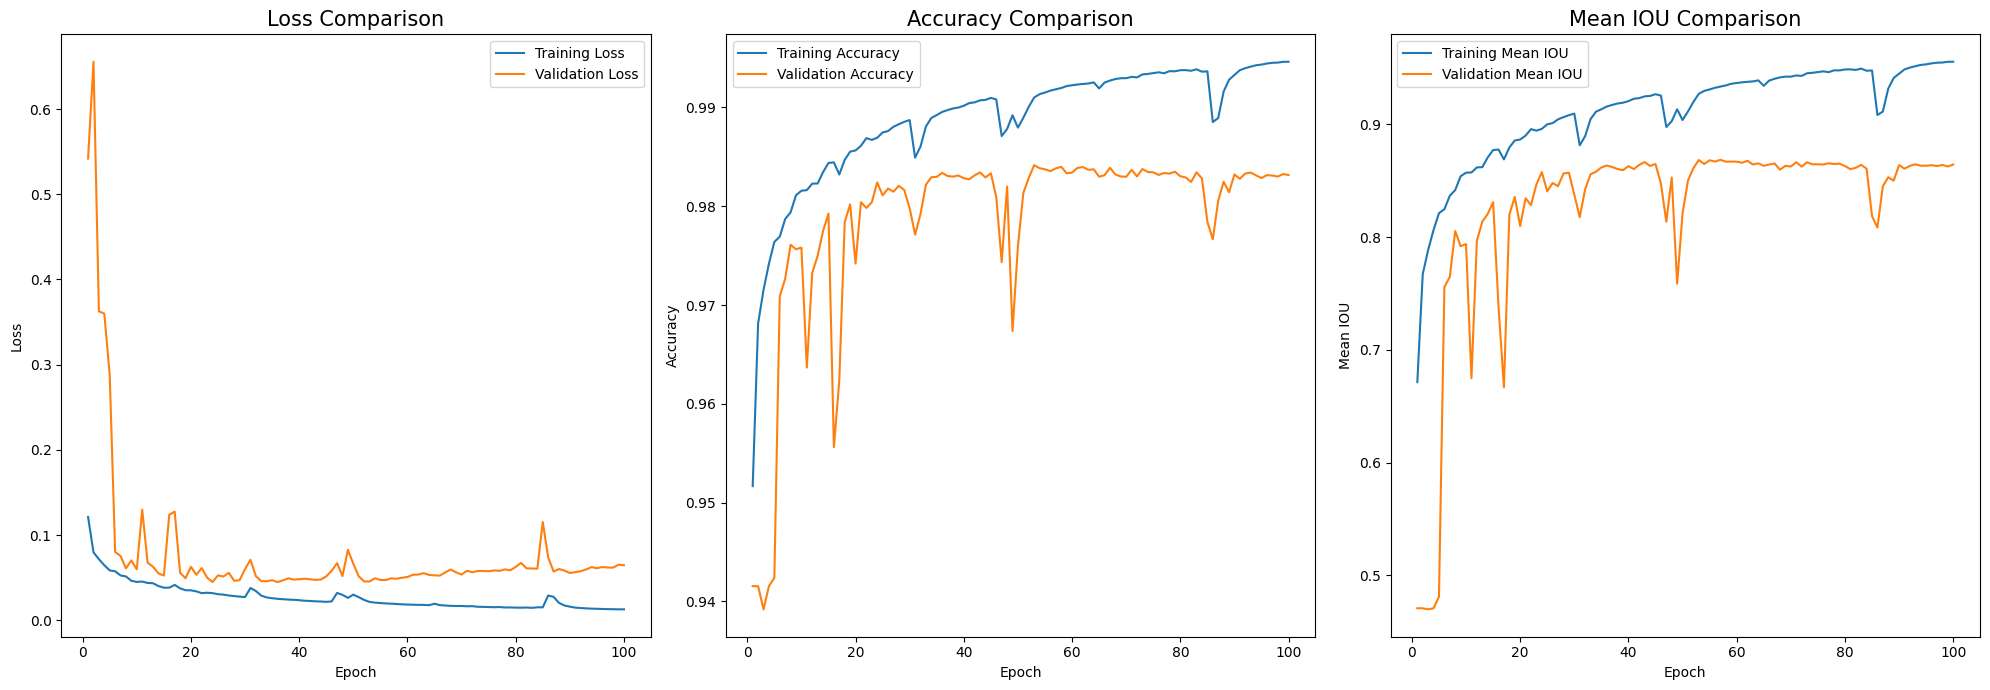

In [ ]:
plot_history(history)

From the above Two model, it is clear that the model withour early callback is overfitting the training data. The model with early callback is performing better on the validation data.

The model's performance has not reached its maximum after 30 training epochs, since the layers were initialized from scratch, more patience may be required. The training and validation performance for most metrics are similar, except for the IOU score. The Mean IOU plot shows that the model starts to overfit after 20-25 epochs when comparing it to accuracy and loss, however, this may be due to the range scale between different plots.


# Transfer Learning using FCN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
import random
import seaborn as sns

from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.vgg16 import VGG16


In [3]:
train_folder = "/content/drive/MyDrive/Computer_Vision/Project_3/dataset/cityscapes_data/sample/train"
valid_folder = "/content/drive/MyDrive/Computer_Vision/Project_3/dataset/cityscapes_data/sample/val"
width = 256
height = 256
classes = 13
batch_size = 10
num_of_training_samples = len(os.listdir(train_folder)) 
num_of_testing_samples = len(os.listdir(valid_folder))

Load Image and Segmentation Mask

In [4]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)
    
    image = img[:,:256]
    mask = img[:,256:]
    
    return image, mask

In this code, we are defining a function called "LoadImage" which takes in two parameters: "name" and "path".

The function begins by using the PIL library's "Image.open()" function to open an image file located at the specified "path" and "name". It then converts the image to a numpy array.

Next, the function is taking a slice of the image array by using colon operator (:) to get the first 256 columns and all the rows of the image array. This slice is then assigned to the variable "image".

Then the function is again taking another slice of the image array by using colon operator (:) to get the remaining columns after 256th column (256th column is excluded) and all the rows of the image array. This slice is then assigned to the variable "mask".

In essence, the function is loading an image, and then splitting it into two separate arrays: one for the image and one for the mask. The image and mask are returned by the function as a tuple.

Bin Segmentation Mask

In [5]:
def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

In this code, we are defining a function called "bin_image" which takes in one parameter: "mask".

The function creates an array called "bins" which contains the values 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240.

Then it uses numpy's "digitize()" function to divide the input "mask" array into bins, such that each element in the "mask" array is assigned to the bin to which it belongs based on the bin edges specified in "bins" array. The function returns the binned image as a new array "new_mask".

In essence, the function is taking an input mask and converting the intensities to discrete values, so that the intensity of each pixel in the mask will be one of the values in the bins array.

Segmentation Masks to Categorical Arrays

In [6]:
def getSegmentationArr(image, classes, width=width, height=height):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

In this code, we are defining a function called "getSegmentationArr" which takes in three parameters: "image", "classes" and width and height. The last two parameters have default values width and height which will be used if no values are passed.

The function first creates an array called "seg_labels" which is a 3D array of zeroes with dimensions of "height", "width", and "classes".

It then takes the first channel of the input "image" by indexing the last dimension of the image array and assigns it to the variable "img".

It then uses a for loop to iterate over each class. For each class, it creates a 2D Boolean array where the value of each element is True if the corresponding element in the "img" array is equal to the current class number, otherwise it is False. Then it casts the Boolean array to integer array using numpy's astype function.

Finally, it assigns the resulting 2D integer array to the corresponding class in the "seg_labels" array and returns the "seg_labels" array.

In essence, the function is taking an input image and converting it into an array of segmentation labels where each pixel is assigned a class label. It is creating an array of the same shape as the original image but with an additional dimension for the number of classes. Each pixel in the resulting array will have the value of 1 for the class it belongs to and 0 for all other classes.

Categorical Arrays to Colored Segmentation Masks

In [7]:
def give_color_to_seg_img(seg, n_classes=13):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

In this code, we are defining a function called "give_color_to_seg_img" which takes in one parameter "seg" and an optional parameter "n_classes". If no value is passed for "n_classes" it defaults to 13.

The function first creates an array called "seg_img" which is a 3D array of zeroes with the same dimensions as the input "seg" array.

It then uses the seaborn library's color_palette function to generate a list of colors called "colors" with "n_classes" number of colors.

It then uses a for loop to iterate over each class. For each class, it creates a 2D Boolean array where the value of each element is True if the corresponding element in the "seg" array is equal to the current class number, otherwise it is False.

It then multiplies each channel of the seg_img with the corresponding color of the class, this way adding the color of the class to the pixels of that class.

Finally, it returns the "seg_img" array.

In essence, the function is taking an input array of segmentation labels and assigning a unique color to each class. It is creating an image with the same shape as the input label array but with an additional dimension for color channels. Each pixel in the resulting image will have the color of the class it belongs to.

Generator function to generate data batches

In [8]:
def DataGenerator(path, batch_size=10, classes=13):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                #file = random.sample(files,1)[0]
                image, mask = LoadImage(file, path)
                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

In this code, we are defining a function called "DataGenerator" which takes in two parameters: "path" and "batch_size" and "classes". If no value is passed for "batch_size" it defaults to 10 and "classes" defaults to 13.

The function first uses the "os.listdir()" function to get a list of all the files in the directory specified by the "path" parameter.

Then it uses a "while True" loop to repeatedly generate batches of data. Inside the loop, it uses a for loop to iterate over the files list by "batch_size" steps. For each iteration, it takes a subset of files called "batch_files" which corresponds to the current batch of files.

For each file in the batch_files, it uses the "LoadImage" function to load the image and mask, then uses the "bin_image" function to bin the mask and uses the "getSegmentationArr" function to get the segmentation labels.

It then appends the image and labels to the "imgs" and "segs" list respectively.

After processing all the files in the batch, it converts the "imgs" and "segs" list to numpy arrays and yields them as a tuple.

In essence, the function is used to generate batches of data for training or testing a model. It loads the images and masks from a specified directory, applies preprocessing on the masks and yields the images and the corresponding segmentation labels in batches.





Visualize Data Samples

In [9]:
train_gen = DataGenerator(train_folder, batch_size=batch_size)
val_gen = DataGenerator(valid_folder, batch_size=batch_size)

In [10]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((10, 256, 256, 3), (10, 256, 256, 13))

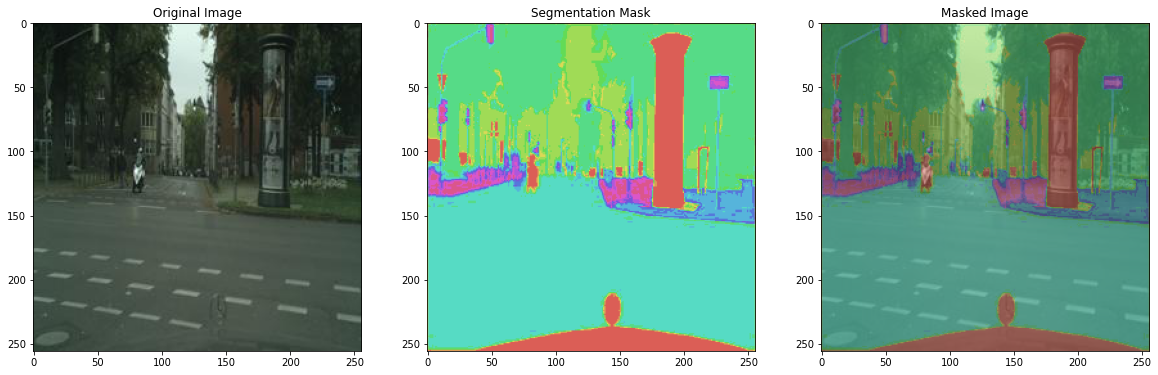

In [11]:
image = imgs[0]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plot.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plot.show()

Segmentation model - FCN+Transfer Learning

In [12]:
def fcn(vgg, classes = 13, fcn8 = False, fcn16 = False):
    pool5 = vgg.get_layer('block5_pool').output 
    pool4 = vgg.get_layer('block4_pool').output
    pool3 = vgg.get_layer('block3_pool').output
    
    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)
    
    conv_8 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
    conv_9 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)
    
    deconv_7 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])
    deconv_8 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(add_1)
    add_2 = Add()([deconv_8, conv_9])
    deconv_9 = Conv2DTranspose(classes, kernel_size=(8,8), strides=(8,8))(add_2)
    
    if fcn8 :
        output_layer = Activation('softmax')(deconv_9)
    elif fcn16 :
        deconv_10 = Conv2DTranspose(classes, kernel_size=(16,16), strides=(16,16))(add_1)
        output_layer = Activation('softmax')(deconv_10)
    else :
        deconv_11 = Conv2DTranspose(classes, kernel_size=(32,32), strides=(32,32))(conv_7)
        output_layer = Activation('softmax')(deconv_11)
    
    model = Model(inputs=vgg.input, outputs=output_layer)
    return model

In this code, we are defining a function called "fcn" which takes in one parameter "vgg" and two optional parameters "classes" and "fcn8" and "fcn16". If no value is passed for "classes" it defaults to 13.

The function begins by getting the output of the last pooling layers of the vgg model, which are 'block5_pool', 'block4_pool' and 'block3_pool' respectively.

It then applies a series of convolutional and transpose convolutional layers, and element-wise addition layers to the output of these pooling layers. Each layer applies different number of filters, kernel size and strides to the input, and also applies relu activation function.

Finally, it applies a transpose convolutional layer with different kernel size and strides depending on the parameter passed to the function. If "fcn8" is set to True, it applies a transpose convolutional layer with kernel size (8,8) and stride (8,8). If "fcn16" is set to True, it applies a transpose convolutional layer with kernel size (16,16) and stride (16,16). Otherwise, it applies a transpose convolutional layer with kernel size (32,32) and stride (32,32).

The final output from the transpose convolutional layer is passed through a softmax activation function.

It then creates a model by taking the input from the vgg model and the output from the final output_layer, and returns the model.

In essence, the function creates a fully convolutional network (FCN) model, using the VGG16 model as a base. The FCN is trained to predict the segmentation labels of an image. The function gives the flexibility to choose the number of classes, and different network architecture by passing different parameters to the function.


In [13]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(width, height, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
model = fcn(vgg, fcn8=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

Train our Model

In [15]:
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
filepath = "/content/drive/MyDrive/Computer_Vision/Project_3/models/fine-tuned.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(train_gen, epochs=10, steps_per_epoch=num_of_training_samples//batch_size,
                       validation_data=val_gen, validation_steps=num_of_testing_samples//batch_size,
                       callbacks=callbacks_list, use_multiprocessing=True)

# Conclusion

We have developed U-net model with and without callbacks. The model without callback was overfitted and didn't work properly. So we used the verison 1 or callback model to make the predictions in the streamlit file as well.

We also used the streamlit to make the predictions on the test images.

We also used transfer learning with FCN model as well. But we can't compare as we didn't have enough time to train the model. We will try to train the model and compare the results in the future.